In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# TicTacToe environment
class TicTacToe:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)  # 3x3 board, 0: empty, 1: agent, -1: human
        self.done = False
        self.current_player = 1  # 1 for agent (X), -1 for human (O)
        return self.board.flatten()

    def check_winner(self):
        for i in range(3):
            if abs(np.sum(self.board[i, :])) == 3 or abs(np.sum(self.board[:, i])) == 3:
                return self.current_player
        if abs(np.sum(np.diag(self.board))) == 3 or abs(np.sum(np.diag(np.fliplr(self.board)))) == 3:
            return self.current_player
        return 0

    def is_full(self):
        return not np.any(self.board == 0)

    def step(self, action):
        row, col = divmod(action, 3)
        if self.board[row, col] == 0 and not self.done:
            self.board[row, col] = self.current_player
            winner = self.check_winner()
            if winner != 0:
                self.done = True
                return self.board.flatten(), 5 if winner == 1 else -5, True  # Agent win: 10, lose: -10
            elif self.is_full():
                self.done = True
                return self.board.flatten(), 0, True  # Draw
            else:
                self.current_player *= -1
                return self.board.flatten(), 0, False
        else:
            return self.board.flatten(), -1, False  # Invalid move

    def get_valid_actions(self):
        return [i for i in range(9) if self.board.flatten()[i] == 0]

    def check_danger(self, board, player):
        # Same check_danger logic (checking if an opponent is about to win)
        for i in range(3):
            if np.sum(board[i, :]) == 2 * player:  # Row check
                for j in range(3):
                    if board[i, j] == 0:
                        return i * 3 + j
            if np.sum(board[:, i]) == 2 * player:  # Column check
                for j in range(3):
                    if board[j, i] == 0:
                        return j * 3 + i
        if np.sum(np.diag(board)) == 2 * player:  # Diagonal check
            for i in range(3):
                if board[i, i] == 0:
                    return i * 3 + i
        if np.sum(np.diag(np.fliplr(board))) == 2 * player:  # Anti-diagonal check
            for i in range(3):
                if board[i, 2 - i] == 0:
                    return i * 3 + (2 - i)
        return None

    def render(self):
        plt.figure(figsize=(6,6))
        plt.plot([1,1], [0,3], color='black', lw=5)
        plt.plot([2,2], [0,3], color='black', lw=5)
        plt.plot([0,3], [1,1], color='black', lw=5)
        plt.plot([0,3], [2,2], color='black', lw=5)

        for i in range(3):
            for j in range(3):
                if self.board[i, j] == 1:
                    plt.text(j+0.5, 2.5-i, 'X', fontsize=60, ha='center', va='center')
                elif self.board[i, j] == -1:
                    plt.text(j+0.5, 2.5-i, 'O', fontsize=60, ha='center', va='center')

        plt.xlim(0, 3)
        plt.ylim(0, 3)
        plt.xticks([])
        plt.yticks([])
        plt.show()




In [2]:


def play_with_agent(agent):
    env = TicTacToe()
    state = env.reset()
    done = False

    while not done:
        env.render()

        if env.current_player == 1:
            # Agent's turn
            valid_actions = env.get_valid_actions()
            action = agent.choose_action(state, valid_actions, env)
            state, reward, done = env.step(action)
        else:
            # Human's turn
            valid_actions = env.get_valid_actions()
            print(f"Valid actions: {valid_actions}")
            action = int(input("Your move (0-8): "))
            if action not in valid_actions:
                print("Invalid move, try again.")
                continue
            state, reward, done = env.step(action)

    env.render()  # Print final state of the board
    if reward == 5:
        print("Agent wins!")
    elif reward == -5:
        print("You win!")
    else:
        print("It's a draw!")


# **Q-Learning**

Episode 0 completed
Episode 500 completed
Episode 1000 completed
Episode 1500 completed


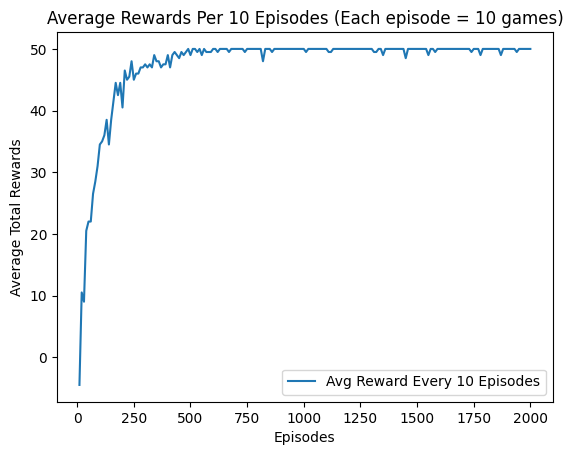

In [3]:
# Q-Learning Agent
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.5):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def get_q_value(self, state, action):
        return self.q_table.get((tuple(state), action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        max_next_q = max([self.get_q_value(next_state, a) for a in range(9)], default=0)
        current_q = self.get_q_value(state, action)
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[(tuple(state), action)] = new_q

    def choose_action(self, state, valid_actions, env):


        win_action = env.check_danger(env.board, 1)  # Check if the agent is about to win
        if win_action is not None and win_action in valid_actions:
            return win_action

        danger_action = env.check_danger(env.board, -1)  # Check if the human is about to win
        if danger_action is not None and danger_action in valid_actions:
            return danger_action

        # Epsilon-greedy exploration
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(valid_actions)  # Exploration

        # Exploitation: pick action with the highest Q-value
        q_values = [self.get_q_value(state, a) for a in valid_actions]
        max_q = max(q_values, default=0)
        best_actions = [a for a in valid_actions if self.get_q_value(state, a) == max_q]
        return random.choice(best_actions)

def train_agent_QLearning(agent, episodes=2000, games_per_episode=10, plot_interval=10):
    env = TicTacToe()
    total_rewards_per_episode = []
    avg_rewards_every_10_episodes = []

    for episode in range(episodes):
        total_reward = 0

        for game in range(games_per_episode):
            state = env.reset()
            done = False
            while not done:
                valid_actions = env.get_valid_actions()
                action = agent.choose_action(state, valid_actions, env)
                next_state, reward, done = env.step(action)
                agent.update_q_value(state, action, reward, next_state)
                total_reward += reward
                state = next_state

        total_rewards_per_episode.append(total_reward)
        #epsilon = 0,5
        if agent.epsilon > 0.01:
              agent.epsilon *= 0.995

        # Every 10 episodes, calculate the average reward and store it
        if (episode + 1) % plot_interval == 0:
            avg_reward = np.mean(total_rewards_per_episode[-plot_interval:])  # Average of last 10 episodes
            avg_rewards_every_10_episodes.append(avg_reward)
           #print(f"Episode {episode+1} completed, Avg reward in last {plot_interval} episodes: {avg_reward}")
        if episode % 500 == 0:
            print(f"Episode {episode} completed")

    # Plot total rewards every 10 episodes
    plt.plot(range(plot_interval, episodes+1, plot_interval), avg_rewards_every_10_episodes, label=f'Avg Reward Every {plot_interval} Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Average Total Rewards')
    plt.legend()
    plt.title(f'Average Rewards Per {plot_interval} Episodes (Each episode = {games_per_episode} games)')
    plt.show()

    return agent

agentQ = QLearningAgent(alpha=0.1, gamma=0.9, epsilon=0.5)
train_agent_QLearning(agentQ, episodes=2000, games_per_episode=10, plot_interval=10)


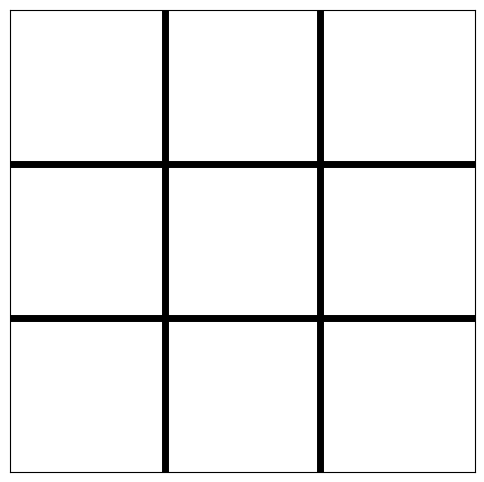

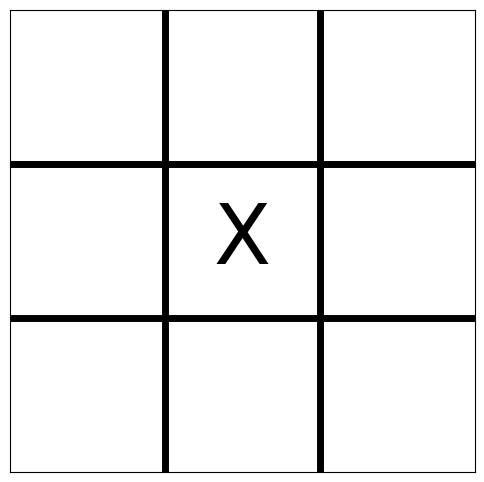

Valid actions: [0, 1, 2, 3, 5, 6, 7, 8]
Your move (0-8): 7


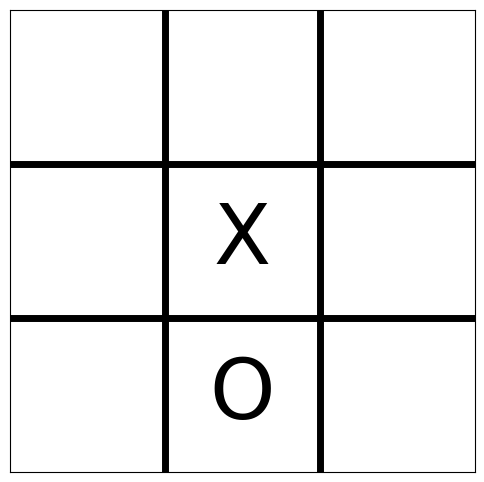

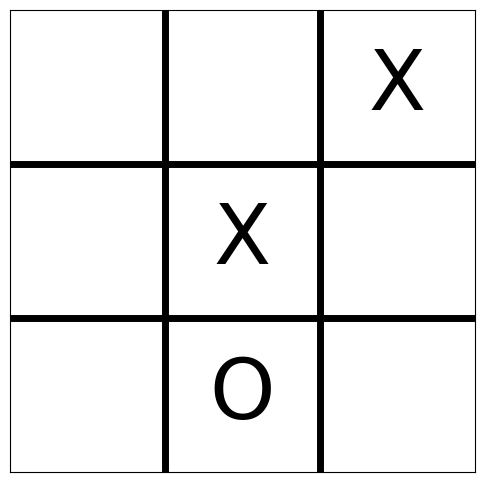

Valid actions: [0, 1, 3, 5, 6, 8]
Your move (0-8): 2
Invalid move, try again.


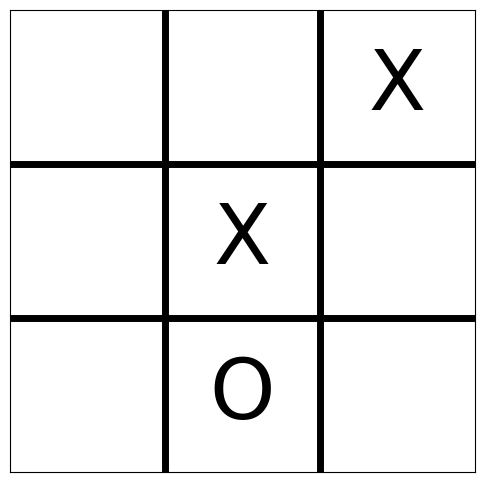

Valid actions: [0, 1, 3, 5, 6, 8]
Your move (0-8): 1


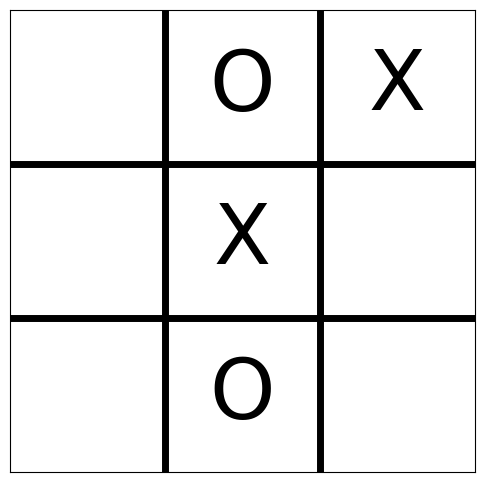

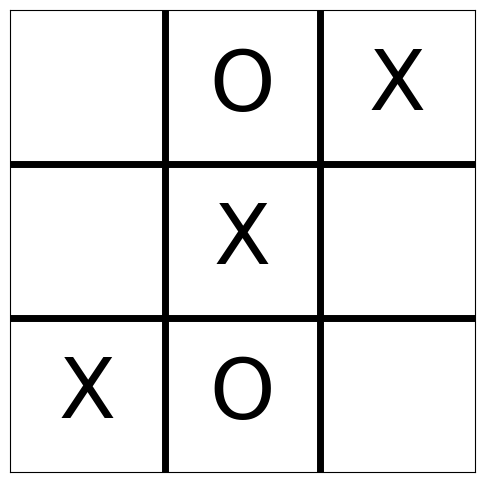

Agent wins!


In [4]:
play_with_agent(agentQ)

# **SARSA**





Episode 0 completed
Episode 500 completed
Episode 1000 completed
Episode 1500 completed


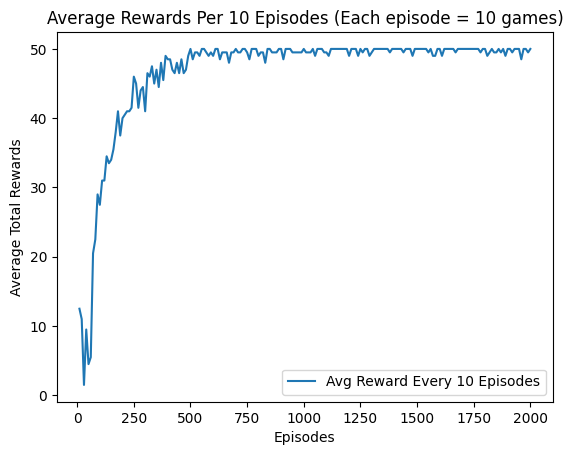

In [5]:
# SARSA Agent
class SARSAAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.5):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def get_q_value(self, state, action):
        return self.q_table.get((tuple(state), action), 0.0)

    def update_q_value(self, state, action, reward, next_state, next_action):
        current_q = self.get_q_value(state, action)
        next_q = self.get_q_value(next_state, next_action)
        new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
        self.q_table[(tuple(state), action)] = new_q

    def choose_action(self, state, valid_actions, env):
        # Win or block opponent logic (same as Q-Learning)
        win_action = env.check_danger(env.board, 1)  # Check if the agent is about to win
        if win_action is not None and win_action in valid_actions:
            return win_action

        danger_action = env.check_danger(env.board, -1)  # Check if the human is about to win
        if danger_action is not None and danger_action in valid_actions:
            return danger_action

        # Epsilon-greedy exploration
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(valid_actions)  # Exploration

        # Exploitation: pick action with the highest Q-value
        q_values = [self.get_q_value(state, a) for a in valid_actions]
        max_q = max(q_values, default=0)
        best_actions = [a for a in valid_actions if self.get_q_value(state, a) == max_q]
        return random.choice(best_actions)


# Train agent with SARSA (each episode consists of multiple games)
def train_agent_sarsa(agent, episodes=2000, games_per_episode=10, plot_interval=10):
    env = TicTacToe()
    total_rewards_per_episode = []
    avg_rewards_every_10_episodes = []

    for episode in range(episodes):
        total_reward = 0

        for game in range(games_per_episode):
            state = env.reset()
            done = False

            # Initialize action for SARSA
            valid_actions = env.get_valid_actions()
            action = agent.choose_action(state, valid_actions, env)

            while not done:
                next_state, reward, done = env.step(action)
                total_reward += reward

                if not done:
                    next_valid_actions = env.get_valid_actions()
                    next_action = agent.choose_action(next_state, next_valid_actions, env)
                else:
                    next_action = None

                # Update Q-value using SARSA
                agent.update_q_value(state, action, reward, next_state, next_action)

                state = next_state
                action = next_action  # Move to the next action

        total_rewards_per_episode.append(total_reward)
        if agent.epsilon > 0.01:
            agent.epsilon *= 0.995  # Decay epsilon

        # Every 10 episodes, calculate the average reward and store it
        if (episode + 1) % plot_interval == 0:
            avg_reward = np.mean(total_rewards_per_episode[-plot_interval:])  # Average of last 10 episodes
            avg_rewards_every_10_episodes.append(avg_reward)

        if episode % 500 == 0:
            print(f"Episode {episode} completed")

    # Plot total rewards every 10 episodes
    plt.plot(range(plot_interval, episodes+1, plot_interval), avg_rewards_every_10_episodes, label=f'Avg Reward Every {plot_interval} Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Average Total Rewards')
    plt.legend()
    plt.title(f'Average Rewards Per {plot_interval} Episodes (Each episode = {games_per_episode} games)')
    plt.show()

    return agent


# Initialize and train the SARSA agent
agentS = SARSAAgent(alpha=0.1, gamma=0.9, epsilon=0.5)
train_agent_sarsa(agentS, episodes=2000, games_per_episode=10, plot_interval=10)


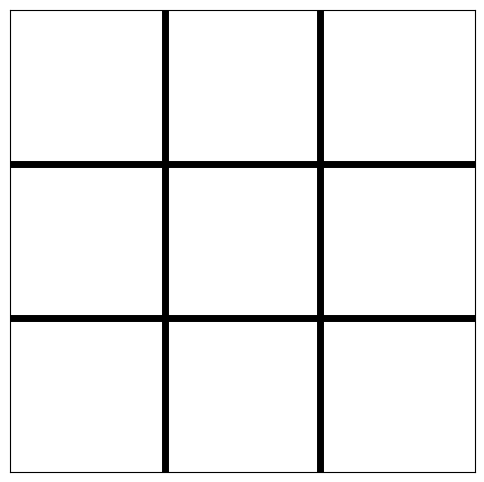

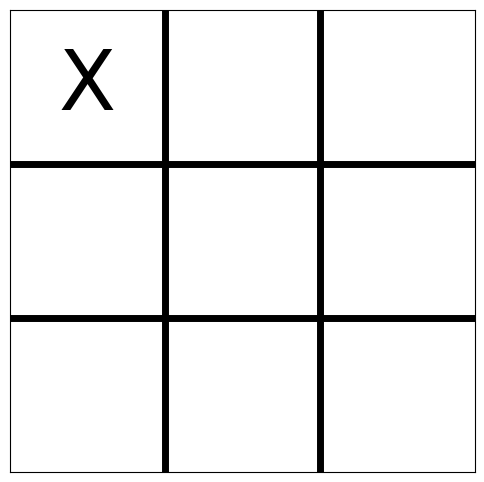

Valid actions: [1, 2, 3, 4, 5, 6, 7, 8]
Your move (0-8): 5


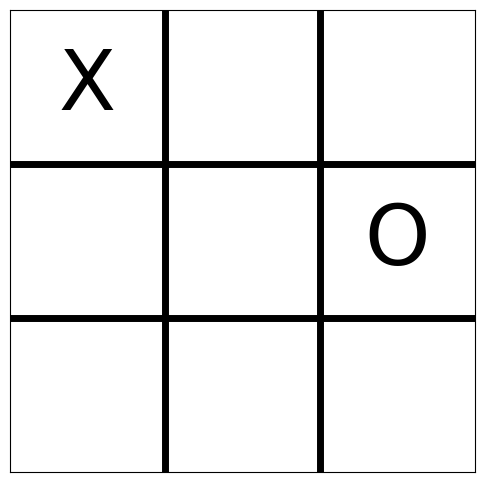

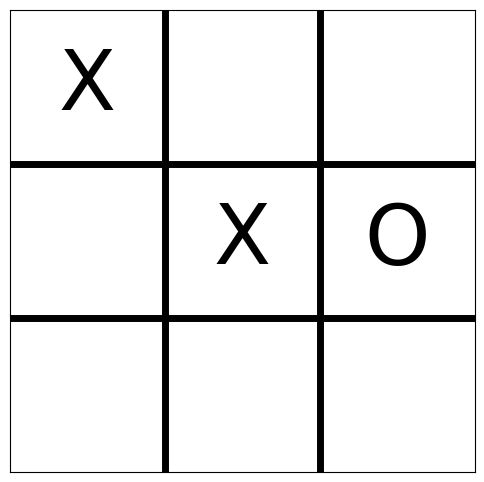

Valid actions: [1, 2, 3, 6, 7, 8]
Your move (0-8): 8


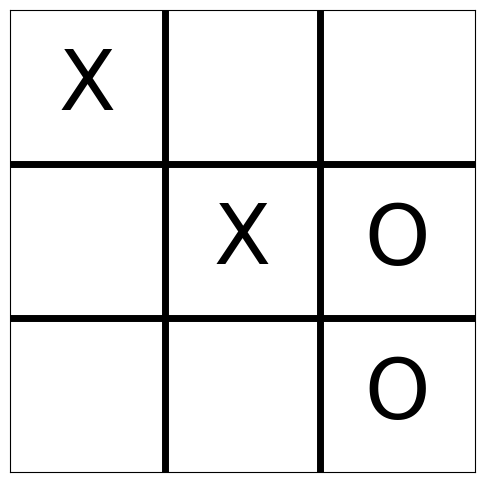

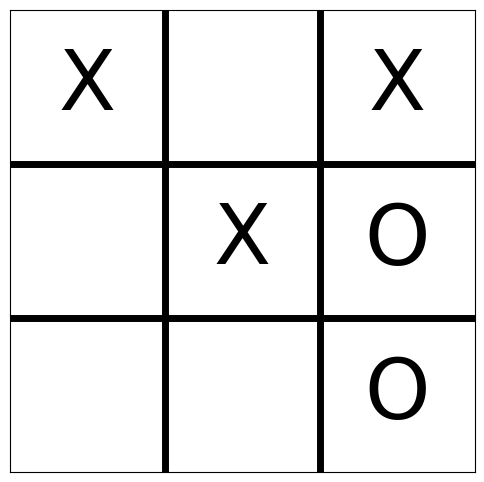

Valid actions: [1, 3, 6, 7]
Your move (0-8): 6


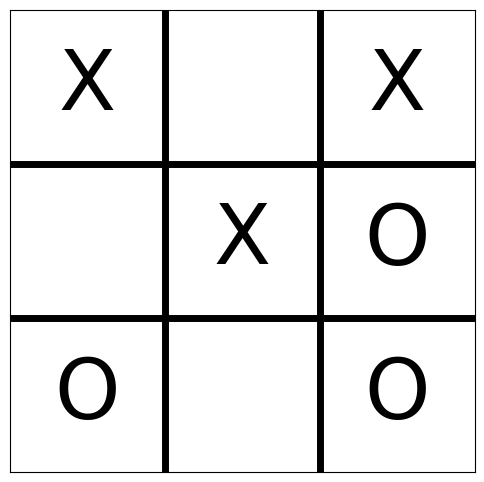

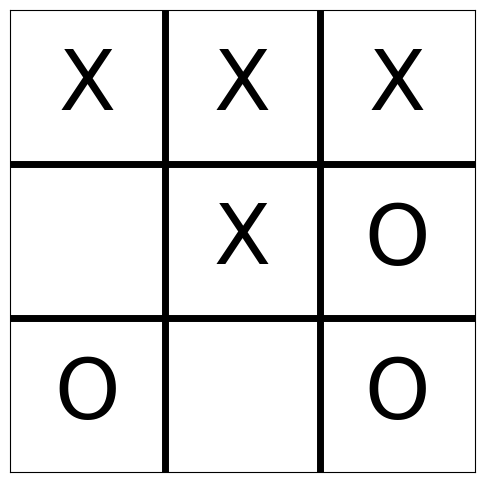

Agent wins!


In [6]:
play_with_agent(agentS)


Match 1: Q-Learning goes first


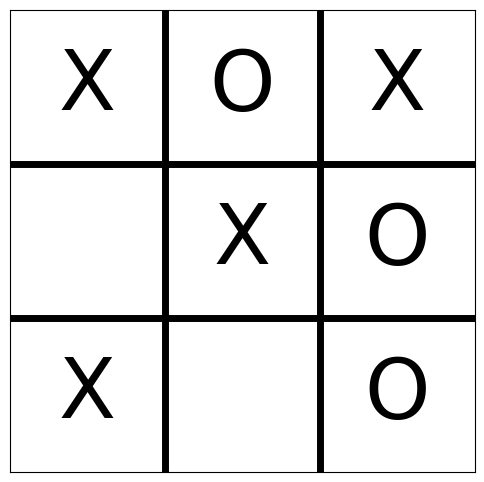

qlearning wins!

Match 2: SARSA goes first


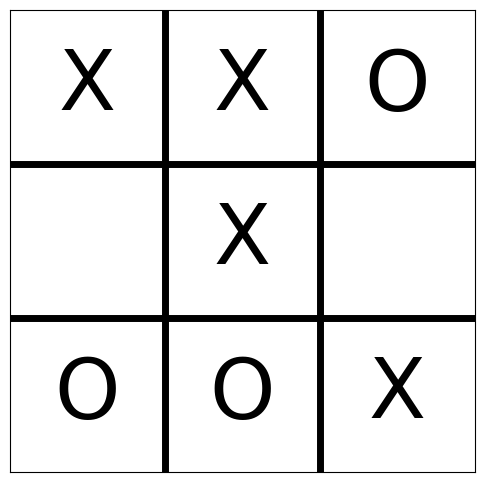

sarsa wins!

Match 3: Q-Learning goes first


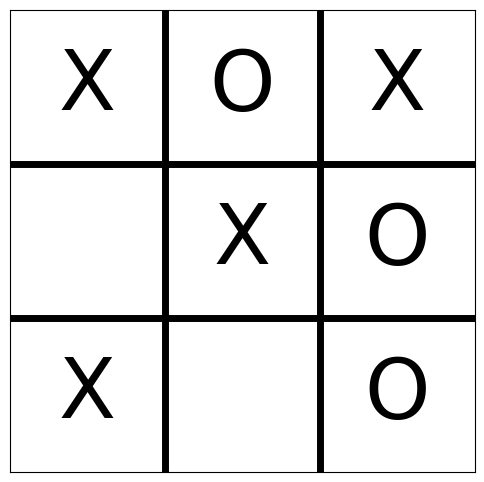

qlearning wins!

Match 4: SARSA goes first


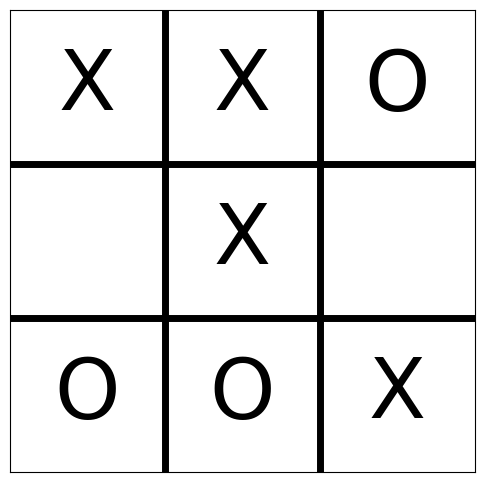

sarsa wins!

Match 5: Q-Learning goes first


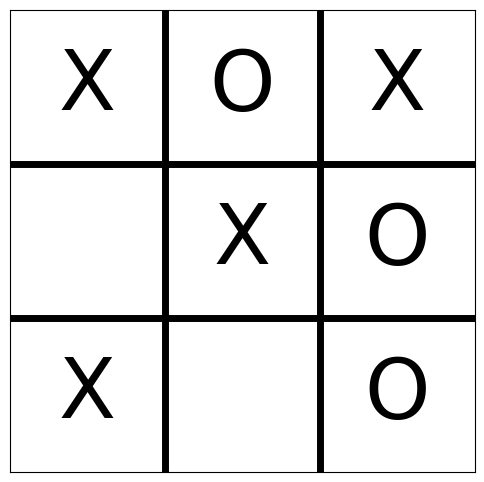

qlearning wins!

Match 6: SARSA goes first


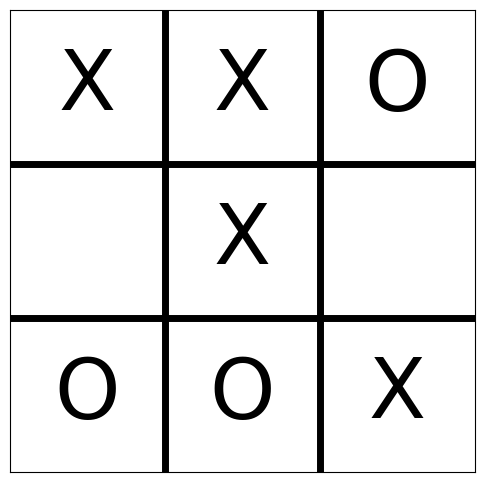

sarsa wins!

Match 7: Q-Learning goes first


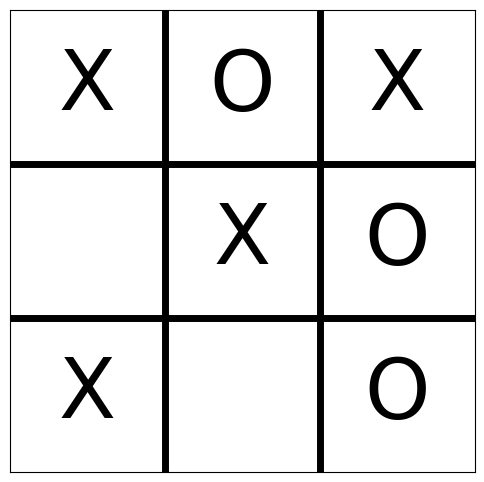

qlearning wins!

Match 8: SARSA goes first


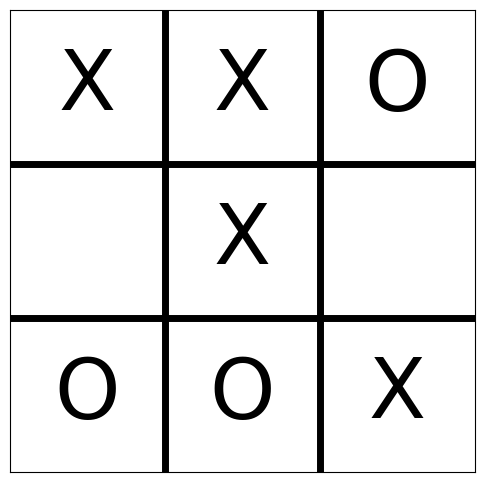

sarsa wins!

Match 9: Q-Learning goes first


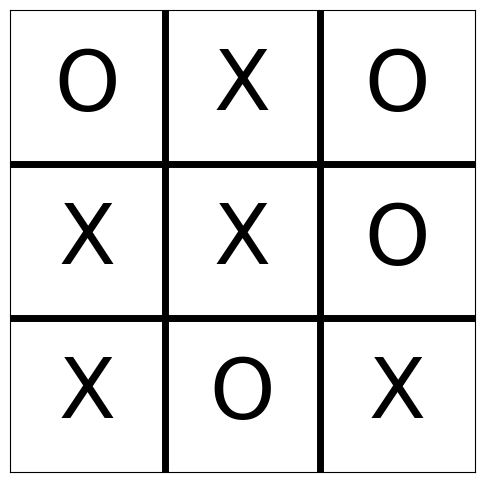

It's a draw!

Match 10: SARSA goes first


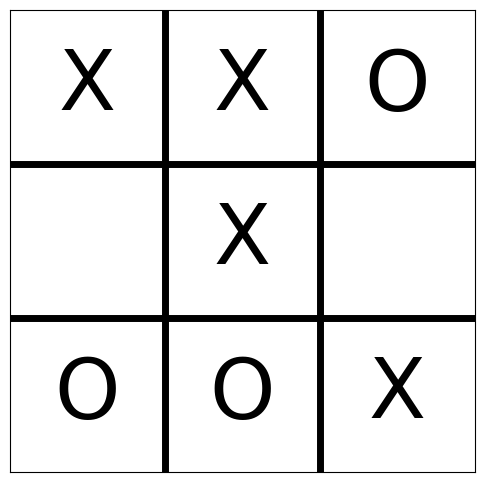

sarsa wins!

Summary of Results:
Q-Learning wins: 4
SARSA wins: 5
Draws: 1


(4, 5, 1)

In [7]:
def play_qlearning_vs_sarsa(q_agent, sarsa_agent, first_player='qlearning'):
    env = TicTacToe()
    state = env.reset()
    done = False
    turn = 1 if first_player == 'qlearning' else -1  # 1 for Q-Learning, -1 for SARSA
    current_player = first_player

    while not done:
        #env.render()  # Optional: visualize the game

        if current_player == 'qlearning':
            valid_actions = env.get_valid_actions()
            action = q_agent.choose_action(state, valid_actions, env)
            next_state, reward, done = env.step(action)
            current_player = 'sarsa'  # Switch to SARSA
        else:
            valid_actions = env.get_valid_actions()
            action = sarsa_agent.choose_action(state, valid_actions, env)
            next_state, reward, done = env.step(action)
            current_player = 'qlearning'  # Switch to Q-Learning

        state = next_state

    env.render()  # Show the final board
    if reward == 5:
        winner = 'qlearning' if turn == 1 else 'sarsa'
        print(f"{winner} wins!")
        return winner
    elif reward == -5:
        winner = 'qlearning' if turn == -1 else 'sarsa'
        print(f"{winner} wins!")
        return winner
    else:
        print("It's a draw!")
        return 'draw'


def play_10_matches(q_agent, sarsa_agent):
    qlearning_wins = 0
    sarsa_wins = 0
    draws = 0

    for i in range(10):
        if i % 2 == 0:  # Q-Learning goes first in even games
            print(f"\nMatch {i+1}: Q-Learning goes first")
            winner = play_qlearning_vs_sarsa(q_agent, sarsa_agent, first_player='qlearning')
        else:  # SARSA goes first in odd games
            print(f"\nMatch {i+1}: SARSA goes first")
            winner = play_qlearning_vs_sarsa(q_agent, sarsa_agent, first_player='sarsa')

        # Record the result
        if winner == 'qlearning':
            qlearning_wins += 1
        elif winner == 'sarsa':
            sarsa_wins += 1
        else:
            draws += 1

    # Print summary of results
    print("\nSummary of Results:")
    print(f"Q-Learning wins: {qlearning_wins}")
    print(f"SARSA wins: {sarsa_wins}")
    print(f"Draws: {draws}")

    return qlearning_wins, sarsa_wins, draws






# Play 10 matches between the Q-Learning agent and the SARSA agent
play_10_matches(agentQ, agentS)
